In [91]:
import pandas as pd
from sklearn.svm import SVR
from pandas.io import gbq
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder,StandardScaler,Normalizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import numpy as np
import seaborn as sns

# Get the data from the bigquery table using gbq function

In [19]:
query = """"SELECT weekday,weather_condition,hour,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_deg,rain,pedestrians FROM heidelberg-wt-visualization"""
ped_wed_df = gbq.read_gbq(query,project_id = "d143241a0def")
ped_wed_df.head(10)

,weekday,weather_condition,hour,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_deg,rain,pedestrians
0,Monday,clear-day,6,297.80,298.17,1009,71,292.19,0.00,0,10000,4.63,160,0.00,156
1,Monday,clear-day,8,295.98,296.41,1008,80,292.35,0.00,0,10000,4.12,160,0.00,811
2,Wednesday,partly-cloudy-night,23,304.98,308.18,1012,54,294.52,0.95,75,10000,1.79,127,0.00,450
3,Thursday,partly-cloudy-night,0,303.39,305.64,1012,56,293.64,0.00,0,10000,1.54,130,0.00,255
4,Thursday,clear-day,8,296.71,297.34,1012,85,294.04,0.00,20,10000,0.89,34,0.00,903
5,Thursday,clear-day,9,296.71,297.34,1012,85,294.04,0.00,0,10000,2.06,90,0.00,1308
6,Thursday,clear-day,10,295.81,296.30,1012,83,292.78,0.00,93,10000,1.34,58,0.00,2198
7,Thursday,partly-cloudy-day,11,295.66,296.29,1012,89,293.76,0.00,90,10000,2.24,60,0.00,2674
8,Thursday,partly-cloudy-day,12,295.71,296.24,1012,85,293.06,0.12,91,10000,2.68,120,0.00,3113
9,Thursday,partly-cloudy-day,14,292.97,293.38,1014,91,291.46,0.61,100,1207,7.20,310,3.16,3231


# create functions for preprocessing and model evaluation

In [21]:

def categorical_separator(X):
    categorical_features = (X.dtypes == 'object')
    object_cols = list(categorical_features[categorical_features].index)
    
    # Create a dataframe for the categorical features
    categorical_dataset = X[object_cols]
    return categorical_dataset



def numercial_separator(X):
    # Get list of Numerical features
    numeric_features = (X.dtypes != 'object')
    numeric_cols = list(numeric_features[numeric_features].index)

    print("Numeric features:")
    print(numeric_cols)
    
    # Create a dataframe for the numeric features
    numeric_dataset = X[numeric_cols]
    return(numeric_dataset)


def remove_constant(df,thr):
    
    #### WARNING : Columns lables are no longaer available!
    
    X,Y = df.iloc[:,:-1],df.iloc[:,-1]
    X_numerical = numercial_separator(X)
    X_categorical = categorical_separator(X)
    
    var_thres=VarianceThreshold(threshold=thr)
    X_numerical = var_thres.fit_transform(X_numerical)
    X_numerical = pd.DataFrame(X_numerical )
    df = pd.concat((X_numerical,X_categorical,Y),axis = 1)
    df.columns = list(range(len(df.columns)))
    return df 
    
def drop_constant_column(dataframe):
    """
    Drops constant value columns of pandas dataframe.
    """
    return dataframe.loc[:, (dataframe != dataframe.iloc[0]).any()]


def encoding_ordinal(df0):
    df = df0.copy()
    idx = list(range(20))
    idx.remove(3)
    Y = df.iloc[:,3]
    X = df.iloc[:,idx]
    X_numerical = numercial_separator(X)
    X_categorical = categorical_separator(X)
    
    ordinal_encoder = OrdinalEncoder()
    X_categorical = pd.DataFrame(ordinal_encoder.fit_transform(X_categorical))
    
    df = pd.concat((X_numerical,X_categorical,Y),axis = 1)
    df.columns = list(range(len(df.columns)))
    return df

def encoding_label(df0):
    df = df0.copy()
    categorical_features = (df.dtypes == 'object')
    object_cols = list(categorical_features[categorical_features].index)
    
    print("Categorical features:")
    print(object_cols)
    # In the Dataset,  categorical features are present
    # Therefore, we will perform Label Encoding on these feature
    le = LabelEncoder()
    for i in object_cols:
        print(df.loc[:,i])
        
        df.loc[:,i] = le.fit_transform(df.loc[:,i])

#     print("\n encoded categorical features\n", df,"\n")
          
    return df

In [22]:
df_categorical = categorical_separator(ped_wed_df)
df_categorical

,weekday,weather_condition
0,Monday,clear-day
1,Monday,clear-day
2,Wednesday,partly-cloudy-night
3,Thursday,partly-cloudy-night
4,Thursday,clear-day
...,...,...
168,Thursday,partly-cloudy-day
169,Thursday,partly-cloudy-day
170,Thursday,partly-cloudy-day
171,Thursday,partly-cloudy-night


In [23]:
df_categorical = encoding_label(df_categorical)

Categorical features:
['weekday', 'weather_condition']
0         Monday
1         Monday
2      Wednesday
3       Thursday
4       Thursday
         ...    
168     Thursday
169     Thursday
170     Thursday
171     Thursday
172     Thursday
Name: weekday, Length: 173, dtype: object
0                clear-day
1                clear-day
2      partly-cloudy-night
3      partly-cloudy-night
4                clear-day
              ...         
168      partly-cloudy-day
169      partly-cloudy-day
170      partly-cloudy-day
171    partly-cloudy-night
172    partly-cloudy-night
Name: weather_condition, Length: 173, dtype: object


In [24]:
df_numerical = numercial_separator(ped_wed_df)

Numeric features:
['hour', 'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'uvi', 'clouds', 'visibility', 'wind_speed', 'wind_deg', 'rain', 'pedestrians']


In [25]:
df_numerical

,hour,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_deg,rain,pedestrians
0,6,297.80,298.17,1009,71,292.19,0.00,0,10000,4.63,160,0.0,156
1,8,295.98,296.41,1008,80,292.35,0.00,0,10000,4.12,160,0.0,811
2,23,304.98,308.18,1012,54,294.52,0.95,75,10000,1.79,127,0.0,450
3,0,303.39,305.64,1012,56,293.64,0.00,0,10000,1.54,130,0.0,255
4,8,296.71,297.34,1012,85,294.04,0.00,20,10000,0.89,34,0.0,903
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,19,291.23,290.79,1019,65,284.56,0.00,0,10000,2.57,270,0.0,2518
169,20,289.62,289.18,1019,71,284.35,0.00,0,10000,1.54,240,0.0,1226
170,21,288.07,287.68,1021,79,284.46,0.00,20,10000,0.60,290,0.0,924
171,22,287.65,287.38,1022,85,285.16,0.00,17,10000,0.40,322,0.0,0


In [26]:
df = pd.concat([df_categorical,df_numerical],axis = 1)
df

,weekday,weather_condition,hour,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_deg,rain,pedestrians
0,1,0,6,297.80,298.17,1009,71,292.19,0.00,0,10000,4.63,160,0.0,156
1,1,0,8,295.98,296.41,1008,80,292.35,0.00,0,10000,4.12,160,0.0,811
2,6,3,23,304.98,308.18,1012,54,294.52,0.95,75,10000,1.79,127,0.0,450
3,4,3,0,303.39,305.64,1012,56,293.64,0.00,0,10000,1.54,130,0.0,255
4,4,0,8,296.71,297.34,1012,85,294.04,0.00,20,10000,0.89,34,0.0,903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,4,2,19,291.23,290.79,1019,65,284.56,0.00,0,10000,2.57,270,0.0,2518
169,4,2,20,289.62,289.18,1019,71,284.35,0.00,0,10000,1.54,240,0.0,1226
170,4,2,21,288.07,287.68,1021,79,284.46,0.00,20,10000,0.60,290,0.0,924
171,4,3,22,287.65,287.38,1022,85,285.16,0.00,17,10000,0.40,322,0.0,0


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

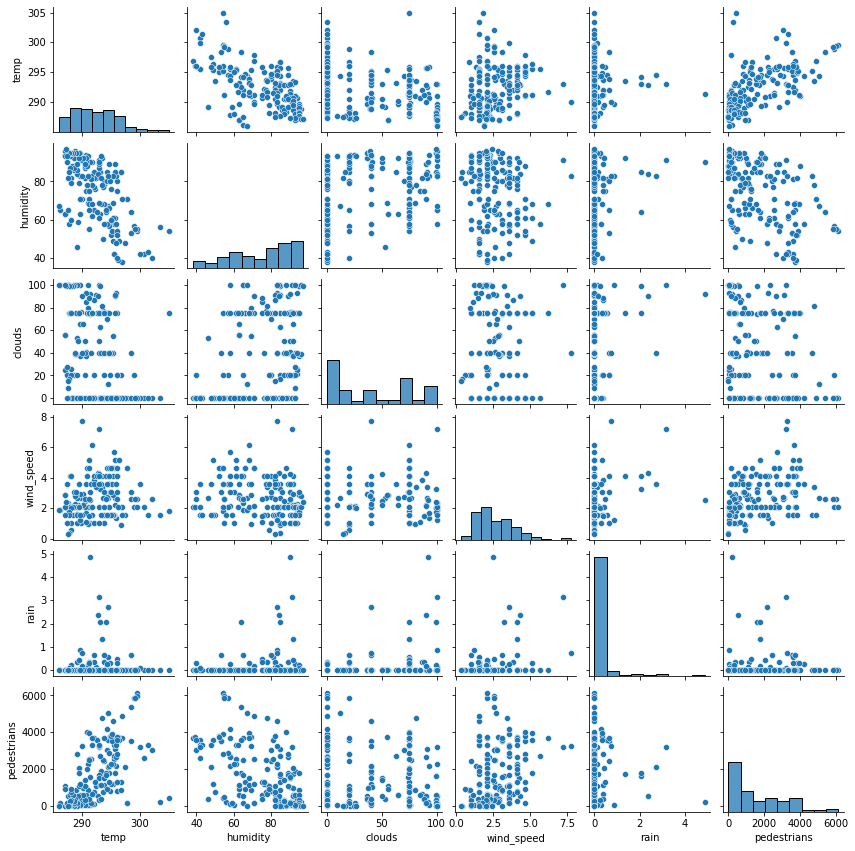

In [97]:
plt.figure()
plot = sns.pairplot(ped_wed_df[['weekday','weather_condition','temp','humidity','clouds','wind_speed','rain','pedestrians']],size=2)

In [27]:
Y = df.iloc[:,-1]
X = df.iloc[:,:-1]

In [ ]:

normalizer = Normalizer()
X = normalizer.fit_transform(X)
X

In [28]:
def data_split(X,Y):
#     Y = df.iloc[:,-1] # Dependent Feature: This column comprises of two classes "Fraud" = Class 1 and "Normal" = Class 0 Transactions
#     X = df.iloc[:,:-1]  # Independent Features

    # Split the dataset into train and test split having a ratio of 80:20
    x_train, x_val, y_train, y_val = train_test_split(X, Y,
                                                      test_size = .2,
                                                      random_state=12)
    return(x_train, x_val, y_train, y_val)


def train_eval_model(x_train, y_train,x_valid,y_valid):
    # Train the Random Forest Classifier with the Training data (x_train and y_train)
    clf =  RandomForestRegressor(n_estimators=100, random_state=0)
    clf = clf.fit(x_train, y_train)
    pred = clf.predict(x_valid)
    mae = mean_absolute_error(y_valid, pred)
    print("Mean absolute error:\n",mae) 
    return clf

def evaluate(clf,x_val,y_val):
    # Evaluate the model performance using the Accuracy Metric
    r2 = r2_score (y_val, clf.predict(x_val))
    plt.scatter(y_val, clf.predict(x_val))
    plt.plot([0,5000],[0,5000])
    plt.title(f"R2 score:{r2:.2f} ")
    plt.xlabel("target")
    plt.ylabel("prediction")
    plt.show()
    



In [42]:
x_train, x_val, y_train, y_val = data_split(X,Y)

# Creating Neural network using different hyperparameters to choose the best one

In [80]:

base_lr = 1e-7
lr = [base_lr*10**r for r in range(1,7)]
h =[(i,) for i in range(1,51,5)]
parameters = {"solver":['lbfgs'],"alpha":lr,"hidden_layer_sizes":h}
MLP = MLPRegressor(random_state=1,max_iter=1000)
clf = GridSearchCV(MLP, parameters)


clf = clf.fit(x_train, y_train)

C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptr

C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarn

In [81]:
clf.cv_results_

{'mean_fit_time': array([0.00700006, 0.19219627, 0.11499095, 0.196416  , 0.22039618,
        0.18152676, 0.11499152, 0.15660138, 0.17099786, 0.12539897,
        0.00300002, 0.16799922, 0.09140549, 0.17911768, 0.14260659,
        0.21478658, 0.13819799, 0.16579771, 0.12239165, 0.10880008,
        0.00359263, 0.10633025, 0.06060648, 0.13819041, 0.20460038,
        0.07699757, 0.19320016, 0.18500056, 0.19820757, 0.09660106,
        0.00319948, 0.18380818, 0.10159669, 0.11940327, 0.17628169,
        0.09999166, 0.1214932 , 0.10530877, 0.17439885, 0.09577665,
        0.00280018, 0.11320815, 0.12800632, 0.14721336, 0.25839376,
        0.09621086, 0.11439314, 0.16698618, 0.15801415, 0.12639499,
        0.00460086, 0.11940694, 0.07279024, 0.09585481, 0.15893917,
        0.1109725 , 0.08679652, 0.15496449, 0.13323755, 0.11639085]),
 'std_fit_time': array([2.09787595e-03, 7.58898448e-02, 1.10975688e-01, 8.63809105e-02,
        1.11019798e-01, 9.47521763e-02, 3.80013813e-02, 8.35744998e-02,
     

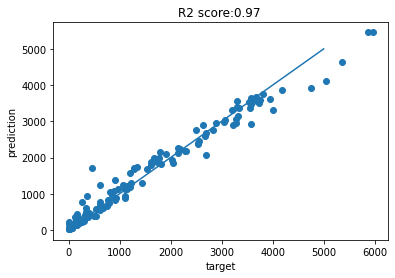

In [85]:
evaluate(clf,x_train,y_train)

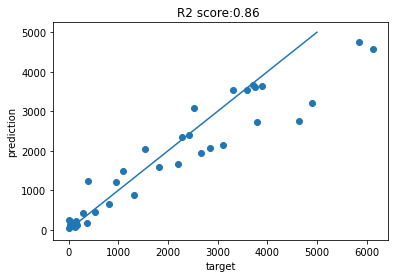

In [86]:
evaluate(clf,x_val,y_t)

## The R2 score of the chosen model is 0.97 for train data and 0.86 for validation data

## Histogram of the values of the model

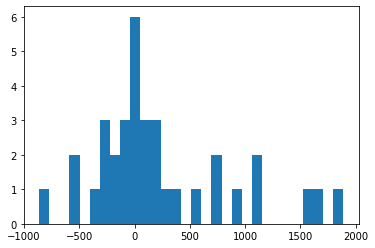

In [89]:
err = y_val - clf.predict(x_val)
plt.hist(err,30)
plt.show()

In [ ]:
from joblib import dump, load
dump(rf_regressor, 'rf_regressor.joblib')